In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import gc
import os,sys
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['feat', 'raw_data.h5', 'sample_submission.csv.zip', 'test.csv.zip', 'train.csv.zip', 'train_sample.csv.zip']


# load data

In [2]:
dtypes = {
            'ip'            : 'uint32',
            'app'           : 'uint16',
            'device'        : 'uint16',
            'os'            : 'uint16',
            'channel'       : 'uint16',
            'is_attributed' : 'uint8',
            'click_id'      : 'uint32',
            }
# train_df = pd.read_csv('../input/train_sample.csv',parse_dates=['click_time'],dtype=dtypes)
train_df = pd.read_csv('../input/train.csv.zip',nrows=1e7,parse_dates=['click_time'],dtype=dtypes)

In [3]:
train_df['hour'] = pd.to_datetime(train_df.click_time).dt.hour
train_df['day']  = pd.to_datetime(train_df.click_time).dt.day

In [4]:
train_df.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,hour,day
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0,14,6
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0,14,6
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0,14,6
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0,14,6
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0,14,6


# possible fraud ?
* Feature1. HIGH FREQUENCY CLICK by  **ip,app,device,os,channel, hour,day ** 

In [5]:
train_df.hour.max()

23

In [6]:
possible_fraud_cnt_per_hour = train_df.groupby(['ip','app','device','os','channel','hour','day'])['click_time'].count().sort_values(ascending=False).reset_index().rename(columns={'click_time':'cnt'})
possible_fraud_cnt_per_hour.head()

,ip,app,device,os,channel,hour,day,cnt
0,180298,19,0,0,213,17,6,1173
1,95766,19,0,0,213,17,6,583
2,105910,19,0,0,213,16,6,574
3,172209,2,1,14,477,16,6,507
4,73487,12,1,19,326,16,6,411


In [7]:
is_att_cnt = train_df.groupby(['ip','app','device','os','channel','hour','day','is_attributed'])['click_time'].count().sort_values(ascending=False).reset_index().rename(columns={'click_time':'cnt'})
is_att_cnt.head()

,ip,app,device,os,channel,hour,day,is_attributed,cnt
0,180298,19,0,0,213,17,6,0,1173
1,95766,19,0,0,213,17,6,0,583
2,105910,19,0,0,213,16,6,0,574
3,172209,2,1,14,477,16,6,0,507
4,73487,12,1,19,326,16,6,0,411


most of is_attributed click frequency is not high

In [8]:
mask_att = is_att_cnt.is_attributed == 1
is_att_cnt[mask_att].sort_values(by=['cnt','ip','app','device'],ascending=[False,False,False,False]).head()

,ip,app,device,os,channel,hour,day,is_attributed,cnt
525279,5314,19,0,24,347,23,6,1,3
1212607,210641,8,1,13,145,21,6,1,2
1279059,207093,19,177,0,213,17,6,1,2
998506,204164,35,1,25,274,16,6,1,2
897384,202986,35,1,13,274,18,6,1,2


In [9]:
# (is_att_cnt[is_att_cnt.is_attributed==0].cnt).plot()

 # Note :
  - potential fraud : click count by (ip,app,device,os,channel,hour,day)  is very high
      - feature MAYBE useful: click counts group by `ip`,`app`,`device`,`os`,`channel`,`hour`,`day

In [10]:
selcols = ['ip','app','device','os','channel','hour','day']
gp = train_df.groupby(selcols)
train_df = train_df.merge(gp.click_time.count().reset_index().rename(columns={'click_time':'click_cnt'}),how='left',on=selcols)
train_df.head(20)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,hour,day,click_cnt
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0,14,6,1
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0,14,6,1
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0,14,6,1
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0,14,6,1
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0,14,6,1
5,18787,3,1,16,379,2017-11-06 14:36:26,NaN,0,14,6,1
6,103022,3,1,23,379,2017-11-06 14:37:44,NaN,0,14,6,1
7,114221,3,1,19,379,2017-11-06 14:37:59,NaN,0,14,6,1
8,165970,3,1,13,379,2017-11-06 14:38:10,NaN,0,14,6,1
9,74544,64,1,22,459,2017-11-06 14:38:23,NaN,0,14,6,1


# Next Click Time by app,ip,os,device

method used from [Baris Kanber](https://www.kaggle.com/bk0000/non-blending-lightgbm-model-lb-0-977?scriptVersionId=3224614)

In [11]:
gc.collect()

299

In [12]:
# D=2**26
# train_temp = train_df.copy()
# train_temp['category'] = (train_temp['ip'].astype(str) + "_" + train_temp['app'].astype(str) + "_" + train_temp['device'].astype(str) \
#     + "_" + train_temp['os'].astype(str)).apply(hash) % D
# click_buffer= np.full(D, 3000000000, dtype=np.uint32)

# train_temp['epochtime']= train_temp['click_time'].astype(np.int64) // 10 ** 9
# next_clicks= []
# for category, t in zip(reversed(train_temp['category'].values), reversed(train_temp['epochtime'].values)):
#     next_clicks.append(click_buffer[category]-t)
#     click_buffer[category]= t
# del(click_buffer)
# QQ= list(reversed(next_clicks))

In [13]:
# nextclicks = pd.Series(QQ)
# nextclicks.value_counts().head()

In [14]:
# train_df['nextclick'] = QQ

In [15]:
# mask = train_df.nextclick < 60
# train_df[mask].head()

## same as Next Clicks

In [16]:
temp = train_df.groupby(['ip','app','os','device'])
train_temp = train_df.copy()
train_temp['shift_1'] = temp.click_time.shift(-1)
train_df['next_click_dt'] = train_temp.shift_1 - train_temp.click_time

In [17]:
train_df.head(10)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,hour,day,click_cnt,next_click_dt
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0,14,6,1,01:29:00
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0,14,6,1,01:32:27
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0,14,6,1,01:38:45
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0,14,6,1,01:25:10
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0,14,6,1,09:22:36
5,18787,3,1,16,379,2017-11-06 14:36:26,NaN,0,14,6,1,NaT
6,103022,3,1,23,379,2017-11-06 14:37:44,NaN,0,14,6,1,NaT
7,114221,3,1,19,379,2017-11-06 14:37:59,NaN,0,14,6,1,04:47:30
8,165970,3,1,13,379,2017-11-06 14:38:10,NaN,0,14,6,1,03:31:25
9,74544,64,1,22,459,2017-11-06 14:38:23,NaN,0,14,6,1,NaT


# Next Next click

In [18]:
temp = train_df.groupby(['ip','app','os','device'])
train_temp = train_df.copy()
train_temp['shift_2'] = temp.click_time.shift(-2)
train_df['next_click_dt2'] = train_temp.shift_2 - train_temp.click_time

# What is prev click time for each app, ip, os,device

In [19]:
temp = train_df.groupby(['ip','app','os','device'])
train_temp = train_df.copy()
train_temp['shift1'] = temp.click_time.shift(1)
train_df['prev_click_dt'] = train_temp.click_time - train_temp.shift1

In [20]:
mask = ~train_df.prev_click_dt.isnull()
train_df[mask].head(20)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,hour,day,click_cnt,next_click_dt,next_click_dt2,prev_click_dt
74,89489,3,1,13,379,2017-11-06 15:20:38,NaN,0,15,6,2,00:48:16,00:48:44,00:07:15
90,109591,3,1,19,379,2017-11-06 15:39:16,NaN,0,15,6,3,00:06:46,NaT,00:09:00
146,53964,3,1,18,379,2017-11-06 15:42:38,NaN,0,15,6,2,00:25:56,00:26:38,00:00:59
190,108942,3,1,19,379,2017-11-06 15:45:18,NaN,0,15,6,4,00:00:54,00:03:45,00:40:50
196,84774,3,1,13,379,2017-11-06 15:45:32,NaN,0,15,6,3,00:13:39,00:19:02,00:00:37
200,42102,3,1,13,379,2017-11-06 15:45:45,NaN,0,15,6,2,00:45:00,01:37:14,00:05:58
203,109591,3,1,19,379,2017-11-06 15:46:02,NaN,0,15,6,3,NaT,NaT,00:06:46
205,108942,3,1,19,379,2017-11-06 15:46:12,NaN,0,15,6,4,00:02:51,00:15:19,00:00:54
208,108881,3,1,13,379,2017-11-06 15:46:15,NaN,0,15,6,4,00:07:31,00:12:11,00:04:17
213,76683,3,1,13,379,2017-11-06 15:46:25,NaN,0,15,6,2,00:44:42,00:44:42,00:00:03


# prev Count by ip,os,device,app

In [21]:
# mask_hfc = train_df.prevClickDiff.dt.seconds<60
train_df.prev_click_dt.value_counts().head(10)

00:00:00    354464
00:00:01    239710
00:00:02     98262
00:00:16     93962
00:00:03     77721
00:00:15     76333
00:00:05     70870
00:00:04     63263
00:00:22     59092
00:00:17     57734
Name: prev_click_dt, dtype: int64

## prev prev click time difference

In [22]:
temp = train_df.groupby(['ip','app','os','device'])
train_temp = train_df.copy()
train_temp['shift2'] = temp.click_time.shift(2)
train_df['prev_click_dt2'] = train_temp.click_time - train_temp.shift2

In [23]:
mask = (~train_df.prev_click_dt2.isnull())
train_df[mask].sort_values('prev_click_dt2').head(10)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,hour,day,click_cnt,next_click_dt,next_click_dt2,prev_click_dt,prev_click_dt2
8436553,7296,15,1,18,430,2017-11-06 23:40:59,NaN,0,23,6,16,00:00:00,00:00:01,0 days,0 days
8983525,94288,3,1,1,115,2017-11-06 23:53:06,NaN,0,23,6,3,NaT,NaT,0 days,0 days
5354561,83797,8,1,27,145,2017-11-06 21:18:21,NaN,0,21,6,3,NaT,NaT,0 days,0 days
694449,108341,2,1,18,205,2017-11-06 16:14:30,NaN,0,16,6,228,00:00:00,00:00:00,0 days,0 days
4624860,95766,14,1,19,480,2017-11-06 19:35:10,NaN,0,19,6,1,00:02:29,00:09:54,0 days,0 days
7414601,66079,9,1,13,215,2017-11-06 23:14:31,NaN,0,23,6,3,00:41:11,00:48:34,0 days,0 days
7534207,102365,3,1,18,417,2017-11-06 23:17:54,NaN,0,23,6,3,NaT,NaT,0 days,0 days
2147586,81167,3,1,6,115,2017-11-06 16:54:33,NaN,0,16,6,1,05:06:46,05:06:47,0 days,0 days
4025335,67581,3,1,36,417,2017-11-06 18:33:25,NaN,0,18,6,2,NaT,NaT,0 days,0 days
1679533,197254,3,1,18,135,2017-11-06 16:40:14,NaN,0,16,6,3,00:27:10,00:28:56,0 days,0 days


> ## count of 
1. prevClick_dt 
2. prevClick_dt2 
3. nextclick

In [24]:
prevclick_cnt = train_df.prev_click_dt.value_counts().reset_index().rename(columns={'index':'prev_click_dt','prev_click_dt':'prev_click_dt_cnt'})
train_df = train_df.merge(prevclick_cnt, how='left', on='prev_click_dt')
# train_df.head()

In [25]:
prevclick2_cnt = train_df.prev_click_dt2.value_counts().reset_index().rename(columns={'index':'prev_click_dt2','prev_click_dt2':'prev_click_dt2_cnt'})
train_df = train_df.merge(prevclick2_cnt,how='left')
train_df.tail(20)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,hour,day,click_cnt,next_click_dt,next_click_dt2,prev_click_dt,prev_click_dt2,prev_click_dt_cnt,prev_click_dt2_cnt
9999980,183610,3,1,10,205,2017-11-07 00:12:03,NaN,0,0,7,1,NaT,NaT,NaT,NaT,NaN,NaN
9999981,145260,1,1,18,153,2017-11-07 00:12:03,NaN,0,0,7,1,NaT,NaT,NaT,NaT,NaN,NaN
9999982,143176,1,1,19,153,2017-11-07 00:12:03,NaN,0,0,7,2,NaT,NaT,00:07:05,00:19:13,2344.0,705.0
9999983,20296,18,1,13,121,2017-11-07 00:12:03,NaN,0,0,7,2,NaT,NaT,00:02:57,06:51:53,4721.0,40.0
9999984,100838,3,1,19,280,2017-11-07 00:12:03,NaN,0,0,7,3,NaT,NaT,00:00:00,00:00:00,354464.0,39242.0
9999985,20770,8,1,37,145,2017-11-07 00:12:03,NaN,0,0,7,1,NaT,NaT,NaT,NaT,NaN,NaN
9999986,20173,9,1,19,334,2017-11-07 00:12:03,NaN,0,0,7,1,NaT,NaT,00:15:40,00:19:05,750.0,723.0
9999987,154971,2,1,19,364,2017-11-07 00:12:03,NaN,0,0,7,1,NaT,NaT,00:13:29,00:14:09,907.0,1011.0
9999988,17321,2,1,13,435,2017-11-07 00:12:03,NaN,0,0,7,1,NaT,NaT,00:02:00,00:15:22,9166.0,947.0
9999989,36642,9,1,19,134,2017-11-07 00:12:03,NaN,0,0,7,2,NaT,NaT,00:00:00,00:00:01,354464.0,59930.0


In [26]:
nextclick_cnt = train_df.next_click_dt.value_counts().reset_index().rename(columns={'index':'next_click_dt','next_click_dt':'next_click_dt_cnt'})
train_df = train_df.merge(nextclick_cnt,how='left')

In [27]:
# train_df.sort_values(by=['prev_click_dt2_cnt','is_attributed'],ascending=[False,False]).head(20)
mask = ~train_df.prev_click_dt2.isnull()
train_df[mask].head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,hour,day,click_cnt,next_click_dt,next_click_dt2,prev_click_dt,prev_click_dt2,prev_click_dt_cnt,prev_click_dt2_cnt,next_click_dt_cnt
203,109591,3,1,19,379,2017-11-06 15:46:02,NaN,0,15,6,3,NaT,NaT,00:06:46,00:15:46,2588.0,814.0,NaN
205,108942,3,1,19,379,2017-11-06 15:46:12,NaN,0,15,6,4,00:02:51,00:15:19,00:00:54,00:41:44,16301.0,283.0,5021.0
271,108942,3,1,19,379,2017-11-06 15:49:03,NaN,0,15,6,4,00:12:28,00:15:45,00:02:51,00:03:45,5021.0,3476.0,967.0
328,51590,3,1,19,379,2017-11-06 15:51:42,NaN,0,15,6,3,00:14:57,00:14:57,00:00:11,00:10:21,48210.0,1397.0,805.0
351,172483,3,1,13,379,2017-11-06 15:53:17,NaN,0,15,6,5,00:04:42,00:05:50,00:06:32,00:27:15,2774.0,443.0,2930.0


# mean encoding 
use target y to mean encode category feature

In [28]:
from sklearn.model_selection import StratifiedKFold

y_tr = train_df.is_attributed.values.astype(np.int8) # target 

skf = StratifiedKFold(5, random_state=0)
skf.get_n_splits(X=train_df,y=y_tr)
print(skf)
train_new = train_df.copy()
cols = ['ip','app','device','os','channel']
# cols_sets = [
#     ['ip','app','os','device'],
#     ['ip'],
    
# ]
for col in cols:
    train_new[col + '_mean_target'] = 0
    

for tr_idx, val_idx in skf.split(train_df,y_tr):
    print('traing idx:{}'.format(tr_idx))
    X_tr ,X_val = train_df.loc[tr_idx], train_df.loc[val_idx]
    for col in cols:
        means = X_val[col].map(X_tr.groupby(col).is_attributed.mean())
        X_val[col + '_mean_target'] = means
    train_new.loc[val_idx] = X_val
prior = train_df.is_attributed.mean()
# train_new.fillna(prior, inplace=True)
train_new[[col+'_mean_target' for col in cols]] = train_new[[col+'_mean_target' for col in cols]].fillna(prior)

StratifiedKFold(n_splits=5, random_state=0, shuffle=False)
traing idx:[1999645 1999646 1999647 ..., 9999997 9999998 9999999]
traing idx:[      0       1       2 ..., 9999997 9999998 9999999]
traing idx:[      0       1       2 ..., 9999997 9999998 9999999]
traing idx:[      0       1       2 ..., 9999997 9999998 9999999]
traing idx:[      0       1       2 ..., 8000165 8000166 8000167]


In [29]:
del train_df; gc.collect()

208

In [30]:
# train_new[[col+'_mean_target' for col in cols]].isnull()
train_new.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,hour,day,...,prev_click_dt,prev_click_dt2,prev_click_dt_cnt,prev_click_dt2_cnt,next_click_dt_cnt,ip_mean_target,app_mean_target,device_mean_target,os_mean_target,channel_mean_target
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0,14,6,...,NaT,NaT,NaN,NaN,81.0,0.000000,0.000647,0.001318,0.001256,0.000797
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0,14,6,...,NaT,NaT,NaN,NaN,75.0,0.000000,0.000647,0.001318,0.001474,0.000797
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0,14,6,...,NaT,NaT,NaN,NaN,55.0,0.000000,0.000647,0.001318,0.001256,0.000797
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0,14,6,...,NaT,NaT,NaN,NaN,83.0,0.001103,0.000470,0.001318,0.001256,0.005546
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0,14,6,...,NaT,NaT,NaN,NaN,1.0,0.000000,0.000647,0.001318,0.001256,0.000797


In [31]:
## pretty slow to conversion timedelta(sec)

# train_new.next_click_dt = train_new.next_click_dt.dt.seconds
# train_new.prev_click_dt = train_new.prev_click_dt.dt.seconds
# train_new.prev_click_dt2 = train_new.prev_click_dt2.dt.seconds
# train_new.dtypes

In [33]:
train_new.next_click_dt = train_new.next_click_dt / np.timedelta64(1,'s')
train_new.next_click_dt2 = train_new.next_click_dt2 / np.timedelta64(1,'s')
train_new.prev_click_dt = train_new.prev_click_dt / np.timedelta64(1,'s')
train_new.prev_click_dt2 = train_new.prev_click_dt2 / np.timedelta64(1,'s')
train_new.dtypes

ip                             uint32
app                            uint16
device                         uint16
os                             uint16
channel                        uint16
click_time             datetime64[ns]
attributed_time                object
is_attributed                   uint8
hour                            int64
day                             int64
click_cnt                       int64
next_click_dt                 float64
next_click_dt2                float64
prev_click_dt                 float64
prev_click_dt2                float64
prev_click_dt_cnt             float64
prev_click_dt2_cnt            float64
next_click_dt_cnt             float64
ip_mean_target                float64
app_mean_target               float64
device_mean_target            float64
os_mean_target                float64
channel_mean_target           float64
dtype: object

In [ ]:
## much faster timedelta conversion 
# td = train_new.next_click_dt2
# train_new.next_click_dt2 = td / np.timedelta64(1,'s')

In [34]:
# target_ip_mean = 
for col in cols:
    train_new['target_'+col+'_mean'] = train_new[col].map(train_new.groupby(col).is_attributed.mean())
# train_new['target_ip_mean'] = train_new.ip.map(train_new.groupby('ip').is_attributed.mean())

    print('corref {} :{:.2f}'.format(col,np.corrcoef(train_new['target_'+col+'_mean'],train_new.is_attributed)[0,1]))


corref ip :0.51
corref app :0.48
corref device :0.22
corref os :0.21
corref channel :0.40


In [51]:
# train_new.describe()

,ip,app,device,os,channel,is_attributed,hour,day,click_cnt,next_click_dt,...,ip_mean_target,app_mean_target,device_mean_target,os_mean_target,channel_mean_target,target_ip_mean,target_app_mean,target_device_mean,target_os_mean,target_channel_mean
count,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,6.954679e+06,...,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07
mean,8.733172e+04,1.285964e+01,3.303871e+01,2.460008e+01,2.526604e+02,1.871700e-03,1.812106e+01,6.069143e+00,8.721788e+00,1.888582e+03,...,1.862799e-03,1.888380e-03,1.869942e-03,1.878374e-03,1.893749e-03,1.871700e-03,1.871700e-03,1.871700e-03,1.871700e-03,1.871700e-03
std,5.567527e+04,1.652680e+01,3.088298e+02,6.159878e+01,1.300376e+02,4.322264e-02,5.653891e+00,2.536975e-01,3.055427e+01,4.830667e+03,...,2.232851e-02,2.096186e-02,9.554639e-03,9.024718e-03,1.765125e-02,2.189511e-02,2.083264e-02,9.458197e-03,8.944025e-03,1.731993e-02
min,9.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00,1.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.216400e+04,3.000000e+00,1.000000e+00,1.300000e+01,1.340000e+02,0.000000e+00,1.600000e+01,6.000000e+00,1.000000e+00,2.200000e+01,...,0.000000e+00,2.375093e-04,1.311965e-03,1.010791e-03,1.824696e-04,0.000000e+00,2.767469e-04,1.325744e-03,1.010818e-03,1.868635e-04
50%,8.197300e+04,1.200000e+01,1.000000e+00,1.800000e+01,2.370000e+02,0.000000e+00,1.800000e+01,6.000000e+00,2.000000e+00,1.280000e+02,...,0.000000e+00,3.869487e-04,1.317819e-03,1.247579e-03,4.069371e-04,0.000000e+00,3.883466e-04,1.325744e-03,1.270583e-03,3.910090e-04
75%,1.211870e+05,1.500000e+01,1.000000e+00,1.900000e+01,3.770000e+02,0.000000e+00,2.200000e+01,6.000000e+00,4.000000e+00,8.540000e+02,...,9.393346e-04,6.470433e-04,1.343108e-03,1.473531e-03,6.849090e-04,1.033912e-03,6.296928e-04,1.325744e-03,1.488705e-03,6.589411e-04
max,2.127740e+05,6.750000e+02,3.545000e+03,7.450000e+02,4.980000e+02,1.000000e+00,2.300000e+01,7.000000e+00,1.173000e+03,3.375600e+04,...,1.000000e+00,1.000000e+00,1.000000e+00,6.250000e-01,8.041879e-01,1.000000e+00,1.000000e+00,1.000000e+00,5.000000e-01,7.088420e-01


In [ ]:
# del X_tr,X_val,category,gp,mask,mask_att,means,next_clicks,nextclick_cnt,nextclicks,possible_fraud_cnt_per_hour,prevclick_cnt,prevclick2_cnt;
gc.collect()

In [ ]:
# del is_att_cnt,temp,tr_idx,train_temp,val_idx;gc.collect()

# lgb model ?

becareful to do CV loop... 

In [35]:
import lightgbm as lgb

In [36]:
categorical = ['ip','app','os','device','channel']
predictors = [
    'ip','app','os','device','channel',
    'hour','day',
    'click_cnt',
    'next_click_dt',
    'next_click_dt_cnt',
    'next_click_dt2',
    'prev_click_dt',
    'prev_click_dt2',
    'prev_click_dt_cnt',
    'prev_click_dt2_cnt',    
    'ip_mean_target',
    'app_mean_target',
    'device_mean_target',
    'os_mean_target',
    'channel_mean_target'
]
target = 'is_attributed'

In [37]:
def lgb_cv(train_new,skf, params={}):
    y_tr = train_new.is_attributed
    objective='binary'
    cores = 4
    metrics='auc'
    early_stopping_rounds=30 
    verbose_eval=True 
    num_boost_round=2000
    categorical_features=categorical
    metrics = 'auc'

    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': objective,
        'metric':metrics,
        'learning_rate': 0.10,
        #'is_unbalance': 'true', # replaced with scale_pos_weight argument
        'num_leaves': 7,  # 2^max_depth - 1
        'max_depth': 3,  # -1 means no limit
        'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 100,  # Number of bucketed bin for feature values
        'subsample': 0.7,  # Subsample ratio of the training instance.
        'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'scale_pos_weight':200, # because training data is extremely unbalanced 
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        'nthread': cores,
        'verbose': 0,
        'metric':metrics
    }
    lgb_params.update(params)
    ### do cv ###
    for train_idx, val_idx in skf.split(train_new,y_tr):
        print("preparing validation datasets...")
        print("val_idx shape:{}".format(val_idx.shape))
        X_tr  = train_new.iloc[train_idx]
        X_val = train_new.iloc[val_idx]
        xgtrain = lgb.Dataset(X_tr[predictors].values, label=X_tr[target].values,
                              feature_name=predictors,
                              categorical_feature=categorical
                              )
        xgvalid = lgb.Dataset(X_val[predictors].values, label=X_val[target].values,
                              feature_name=predictors,
                              categorical_feature=categorical
                              )
        evals_results = {}
        print('lgb training...')
        bst = lgb.train(lgb_params, 
                         xgtrain, 
                         valid_sets=[xgtrain,xgvalid], 
                         valid_names=['train','valid'], 
                         evals_result=evals_results, 
                         num_boost_round=num_boost_round,
                         early_stopping_rounds=early_stopping_rounds,
                         verbose_eval=10, 
                         feval=None)
        print("\nModel Report")
        print("bst.best_iteration: ", bst.best_iteration)
        print(metrics+":", evals_results['valid'][metrics][bst.best_iteration-1])
        lgb.plot_importance(bst)


    
        

preparing validation datasets...
val_idx shape:(2000001,)
lgb training...


C:\Program Files\Anaconda3\envs\py36\lib\site-packages\lightgbm\basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Program Files\Anaconda3\envs\py36\lib\site-packages\lightgbm\basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.965339	valid's auc: 0.951047
[20]	train's auc: 0.972739	valid's auc: 0.963886
[30]	train's auc: 0.977709	valid's auc: 0.967331
[40]	train's auc: 0.981234	valid's auc: 0.97062
[50]	train's auc: 0.984318	valid's auc: 0.972
[60]	train's auc: 0.985886	valid's auc: 0.973394
[70]	train's auc: 0.987015	valid's auc: 0.973792
[80]	train's auc: 0.987977	valid's auc: 0.97426
[90]	train's auc: 0.98881	valid's auc: 0.974624
[100]	train's auc: 0.989458	valid's auc: 0.974919
[110]	train's auc: 0.989962	valid's auc: 0.975315
[120]	train's auc: 0.990208	valid's auc: 0.975396
[130]	train's auc: 0.990568	valid's auc: 0.975546
[140]	train's auc: 0.99081	valid's auc: 0.975358
[150]	train's auc: 0.991014	valid's auc: 0.975326
Early stopping, best iteration is:
[128]	train's auc: 0.99049	valid's auc: 0.975572

Model Report
bst.best_iteration:  128
auc: 0.975572003558
preparing validation datasets...
val_idx shape:(2000001,)
lgb

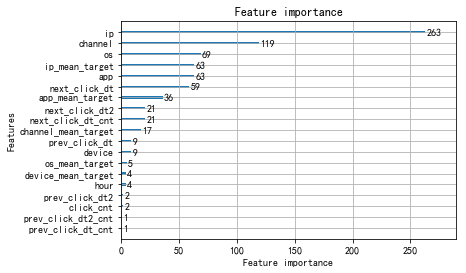

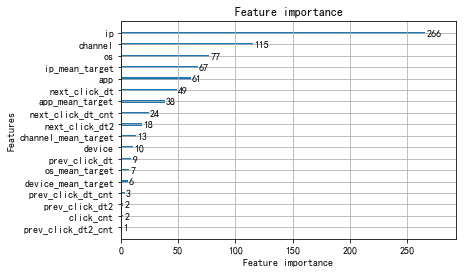

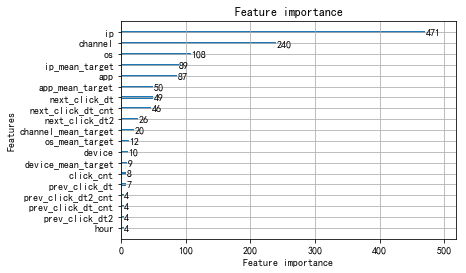

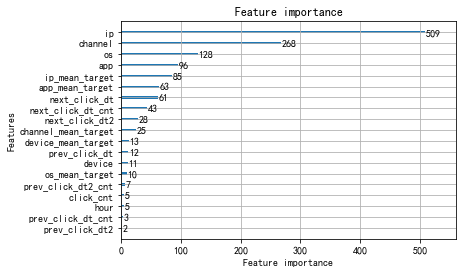

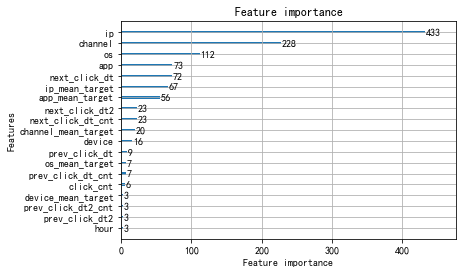

In [38]:
lgb_cv(train_new,skf)

In [ ]:
# 0.975 ip,channel,os,ip_mean_target,app,next_click_dt,app_mean_target,next_click_dt2, next_click_dt_cnt, channel_mean_target,
# prev_click_dt, device, os_mean_target, device_mean_target

In [39]:
predictors

['ip',
 'app',
 'os',
 'device',
 'channel',
 'hour',
 'day',
 'click_cnt',
 'next_click_dt',
 'next_click_dt_cnt',
 'next_click_dt2',
 'prev_click_dt',
 'prev_click_dt2',
 'prev_click_dt_cnt',
 'prev_click_dt2_cnt',
 'ip_mean_target',
 'app_mean_target',
 'device_mean_target',
 'os_mean_target',
 'channel_mean_target']

In [ ]:
train_df = train_new

len_train = 100000 
val_size = 30000
val_df = train_df[(len_train-val_size):len_train]
train_df = train_df[:(len_train-val_size)]

In [ ]:
print('shape of train_df:{}'.format(train_df.shape))
print('shape of val_df:{}'.format(val_df.shape))

In [ ]:
objective='binary'
cores = 4
metrics='auc'
early_stopping_rounds=30 
verbose_eval=True 
num_boost_round=2000
categorical_features=categorical
metrics = 'auc'

lgb_params = {
    'boosting_type': 'gbdt',
    'objective': objective,
    'metric':metrics,
    'learning_rate': 0.10,
    #'is_unbalance': 'true', # replaced with scale_pos_weight argument
    'num_leaves': 7,  # 2^max_depth - 1
    'max_depth': 3,  # -1 means no limit
    'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 100,  # Number of bucketed bin for feature values
    'subsample': 0.7,  # Subsample ratio of the training instance.
    'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
    'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
    'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'scale_pos_weight':200, # because training data is extremely unbalanced 
    'subsample_for_bin': 200000,  # Number of samples for constructing bin
    'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
    'reg_alpha': 0,  # L1 regularization term on weights
    'reg_lambda': 0,  # L2 regularization term on weights
    'nthread': cores,
    'verbose': 0,
    'metric':metrics
}

print("preparing validation datasets")
xgtrain = lgb.Dataset(train_df[predictors].values, label=train_df[target].values,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )
xgvalid = lgb.Dataset(val_df[predictors].values, label=val_df[target].values,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )
evals_results = {}
print('lgb training...')
bst = lgb.train(lgb_params, 
                 xgtrain, 
                 valid_sets=[xgtrain,xgvalid], 
                 valid_names=['train','valid'], 
                 evals_result=evals_results, 
                 num_boost_round=num_boost_round,
                 early_stopping_rounds=early_stopping_rounds,
                 verbose_eval=10, 
                 feval=None)
print("\nModel Report")
print("bst.best_iteration: ", bst.best_iteration)
print(metrics+":", evals_results['valid'][metrics][bst.best_iteration-1])



In [ ]:
gc.collect()

In [ ]:
lgb.plot_importance(bst)

In [ ]:
pd.DataFrame({'features':bst.feature_name() ,'importance':bst.feature_importance()})

______


# Text features ?

In [ ]:
text_features = pd.DataFrame()
text_features['txt_feat'] = 'ip'+ train_df['ip'].astype(str) + 'app'+train_df.app.astype(str) + 'os' + train_df.os.astype(str) + 'channel' + train_df.channel.astype(str)

In [ ]:
text_features.head()

## Tfidf + truncated svd

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
text_features = pd.Series(np.concatenate(text_features.values))
tv = TfidfVectorizer(lowercase=False, ngram_range=(1,2))
tv_feat = tv.fit_transform(text_features.values)
print('shape of tfidf Vectorizer:{}'.format(tv_feat.shape))

In [ ]:
### svd 
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=20, random_state=0)
tv_svd_features = svd.fit_transform(tv_feat)

In [ ]:
tv_svd_features.shape

In [ ]:
# del svd; tv_feat; 
gc.collect()

## Binary tfidf + svd

In [ ]:
## binary tfidf
tvb_features = tv_feat.astype(bool).astype(float)

## svd
svd = TruncatedSVD(n_components=20, random_state=0)
tvb_svd_features = svd.fit_transform(tvb_features)
print('shape of tvb features:{}'.format(tvb_svd_features.shape))
print('memory used (tvb_svd_features):{.3f}'.format(sys.getsizeof(tvb_svd_features)/(1024*1024*1024)))

## Hashing  + truncated SVD

In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer

hv = HashingVectorizer(ngram_range=(1, 2), lowercase=False)
hv_features = hv.fit_transform(text_features).tocsr()
print('shape of hv features:{}'.format(hv_features.shape))

svd = TruncatedSVD(n_components=20, random_state=0)
hv_svd_features = svd.fit_transform(hv_features)

In [ ]:
print('memory used (hv_svd_features):{:.3f}'.format(sys.getsizeof(hv_svd_features)/(1024*1024*1024)))

## Binary Hashing + truncated SVD

In [ ]:
hvb_features = hv_features.astype(bool).astype(float)

svd = TruncatedSVD(n_components=20, random_state=0)
hvb_svd_features = svd.fit_transform(hvb_features)

print(sys.getsizeof(hvb_svd_features)/(1024*1024*1024))

## Stack 1-4

In [ ]:
text_features = np.concatenate([tv_svd_features,tvb_svd_features, hv_svd_features, hvb_svd_features],axis=1)
text_features_df = pd.DataFrame(data=text_features, columns=['text_f_'+str(i) for i in range(80)])
gc.collect()

In [ ]:
text_features_df.head()

In [ ]:
sns.set(rc={'figure.figsize':(12,5)});
plt.figure(figsize=(12,5));

In [ ]:
mask = text_features_df.text_f_0>0.1
text_features_df.text_f_0[mask]

In [ ]:
y = train_df.is_attributed
y.value_counts()

In [ ]:
text_features_df['y'] = y

In [ ]:
mask_1 = text_features_df.y==1
mask_0 = text_features_df.y==0

downloaded = text_features_df[mask_1]
just_click = text_features_df[mask_0]

In [ ]:
sns.heatmap(just_click.append(downloaded),center=0)

In [ ]:
sns.heatmap(just_click,center=0)

In [ ]:
sns.heatmap(just_click.iloc[0:100,:])

In [ ]:
sum(just_click.iloc[207,:]<-0.2)

In [ ]:
pd.Series(np.where(just_click<-0.1)[0]).unique()